In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata
from get_draws.api import get_draws
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
# define relevant age group and location ids
ages = list(range(7,16))
locs = [165, 161, 214, 182] # pakistan, bangladesh, nigeria, malawi

# note: always want sex_id=2

# 1. Custom TMREL

In [3]:
# pull mean population hemoglobin levels
pop_hb = get_draws('modelable_entity_id',
                10487,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
hb_prepped = pop_hb.set_index(['location_id','age_group_id']).sort_index()
hb = hb_prepped.drop(columns=[c for c in hb_prepped.columns if 'draw' not in c])
hb.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                   
161         7             131.576669  130.006851  126.753823  128.018065   
            8             118.922773  126.221582  123.354380  126.262134   
            9             119.445416  119.744885  123.663548  124.283216   
            10            125.283728  125.009121  119.397039  122.817539   
            11            125.122521  121.147369  124.487696  128.703954   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             133.273591  131.115555  130.538169  127.788556   
            8             124.932018  122.562494  124.733401  123.766130   
            9             118.579743  124.817976  123.868556  121.465009   
            10            123.870315  121.480207  122.020435  124.570332   
            11            127.822311  125.583439  122.830292  124.109611   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             127.888119  134.269665  ...  132.629892  127.563386   
            8             126.417171  128.350657  ...  128.983925  125.823625   
            9             121.658608  119.139191  ...  127.191962  121.699027   
            10            124.744182  119.359498  ...  121.166555  119.789437   
            11            122.808416  123.786324  ...  114.836797  125.800045   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             131.561974  128.479080  130.254982  130.120093   
            8             128.289240  130.669737  119.897130  127.467974   
            9             120.712246  121.153322  121.370690  125.672017   
            10            125.065134  124.389494  121.221193  121.139373   
            11            115.827505  125.078032  120.858680  124.079560   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             132.948881  131.693836  129.286983  129.131233  
            8             124.626547  123.436502  123.562551  128.478574  
            9             124.850055  120.869506  120.472913  125.833589  
            10            124.053072  125.456108  120.019112  122.695076  
            11            127.209902  126.128345  122.630509  120.700463  

[5 rows x 1000 columns]

In [4]:
meids = [2022,#stage 5 cdk
        10733,#stage 4 ckd
        10732,#stage 3 ckd
        3121,#symptomatic uterine fibroids
        18741,#menstrual disorders 
        3104,#crohn's disease
        3103,#ulcerative colitis
        3620]#maternal hemorrhage adjusted for live births

causes = [521,#cirrhosis
         528,#gastritis
         527,#peptic ulcer disease
         619,#endocrine,metabolic,etc.
         408,#other infectious
         363,#hookworm
         365,#other ntds
         351,#schisto
         390,#dietary iron deficiency
         389,#vitamin a deficiency
         ]
         
sequelae = [22989, 22990, 22991, 22992, 22993, 22999, 23000, 23001, 23002,
       23003, 23009, 23010, 23011, 23012, 23013, 23019, 23020, 23021,
       23022, 23023] #ESRD on dialysis

p_meid = get_draws('modelable_entity_id',
                meids,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                measure_id=5,
                metric_id=3,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4')

p_cause = get_draws('cause_id',
                causes,
                source='como',
                location_id=locs,
                age_group_id=ages,
                measure_id=5,
                metric_id=3,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step5')

p_seq = get_draws('sequela_id',
                sequelae,
                source='como',
                location_id=locs,
                age_group_id=ages,
                measure_id=5,
                metric_id=3,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step5')

In [5]:
p_meid_prepped = p_meid.set_index(['location_id','age_group_id','modelable_entity_id'])
p_meid_prepped = p_meid_prepped.drop(columns=[c for c in p_meid_prepped.columns if 'draw' not in c])

shifts_meid = pd.DataFrame()
shifts_meid['modelable_entity_id'] = meids
shifts_meid['shift'] = [32.43,#stage 5 ckd
                       21.83,#stage 4 ckd
                       11.84,#stage 3 ckd
                       13.7,#uterine fibroids
                       3,#menstrual disorders
                       23,#crohns
                       20,#ulcertaive colitis
                       6.8]#maternal hemorrhage

shiftprev_meid = p_meid_prepped.reset_index().merge(shifts_meid, on='modelable_entity_id')
for i in list(range(0,1000)):
    shiftprev_meid[f'draw_{i}'] = shiftprev_meid[f'draw_{i}'] * shiftprev_meid['shift']
shiftprev_meid = shiftprev_meid.drop(columns=['shift','modelable_entity_id'])
shiftprev_meid.head()

,location_id,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,161,7,0.006302,0.004085,0.008044,0.005276,0.004911,0.005094,0.004584,0.002583,...,0.004434,0.004446,0.003735,0.003046,0.002720,0.004758,0.005047,0.005258,0.003427,0.006875
1,161,8,0.014319,0.014005,0.017128,0.014663,0.009816,0.012061,0.013717,0.006572,...,0.011086,0.009368,0.009472,0.014687,0.010387,0.011313,0.015556,0.007520,0.010600,0.013343
2,161,9,0.025174,0.032054,0.024269,0.025727,0.019123,0.024006,0.032184,0.019156,...,0.017520,0.019221,0.015613,0.034249,0.028053,0.015300,0.024693,0.018944,0.020739,0.026233
3,161,10,0.032663,0.051155,0.030505,0.041270,0.033662,0.045648,0.043232,0.035401,...,0.032505,0.046291,0.025611,0.047497,0.028211,0.028762,0.019718,0.032725,0.029376,0.046719
4,161,11,0.047409,0.082447,0.038819,0.039085,0.045405,0.067600,0.060599,0.064824,...,0.053428,0.055689,0.045133,0.078941,0.039779,0.057472,0.047069,0.038653,0.063106,0.052650


In [6]:
p_cause_prepped = p_cause.set_index(['location_id','age_group_id','cause_id'])
p_cause_prepped = p_cause_prepped.drop(columns=[c for c in p_cause_prepped.columns if 'draw' not in c])

shifts_cause = pd.DataFrame()
shifts_cause['cause_id'] = causes
shifts_cause['shift'] = [18,#cirrhosis
                         15.11,#gastritis
                         15.11,#peptic ulcer disease
                         3,#endo
                         3,#infectious
                         2.08,#hookworm
                         3,#ntd other
                         2.8,#schisto
                         4.01,#dietary iron deficiency
                         3.6]#vitamin a deficiency

shiftprev_cause = p_cause_prepped.reset_index().merge(shifts_cause, on='cause_id')
for i in list(range(0,1000)):
    shiftprev_cause[f'draw_{i}'] = shiftprev_cause[f'draw_{i}'] * shiftprev_cause['shift']
shiftprev_cause = shiftprev_cause.drop(columns=['shift','cause_id'])
shiftprev_cause.head()

,location_id,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,161,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,161,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,161,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,161,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,161,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
p_seq_prepped = p_seq.set_index(['location_id','age_group_id','sequela_id'])
p_seq_prepped = p_seq_prepped.drop(columns=[c for c in p_seq_prepped.columns if 'draw' not in c])
shiftprev_seq = pd.DataFrame.copy(p_seq_prepped.reset_index())
shiftprev_seq['shift'] = 30.7

for i in list(range(0,1000)):
    shiftprev_seq[f'draw_{i}'] = shiftprev_seq[f'draw_{i}'] * shiftprev_seq['shift']
shiftprev_seq = shiftprev_seq.drop(columns = ['shift','sequela_id'])
shiftprev_seq.head()

,location_id,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,161,7,0.000002,5.306649e-07,7.160723e-07,0.000001,3.836562e-07,0.000001,5.875200e-07,8.380272e-07,...,6.085346e-07,2.301578e-07,7.487039e-07,6.375855e-07,3.478746e-07,0.000002,4.233542e-07,4.444036e-07,0.000001,8.241778e-07
1,161,7,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
2,161,7,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
3,161,7,0.000012,2.103293e-05,1.641859e-05,0.000032,1.013257e-05,0.000009,2.992258e-05,2.137337e-05,...,1.568052e-05,1.153159e-05,1.934393e-05,1.430610e-05,1.019860e-05,0.000042,1.286603e-05,7.989994e-06,0.000028,2.311891e-05
4,161,7,0.000031,3.744141e-05,3.872812e-05,0.000038,1.297593e-05,0.000048,3.315993e-05,4.667333e-05,...,3.377779e-05,3.072719e-05,1.542690e-05,4.901957e-05,1.625478e-05,0.000037,1.761372e-05,1.836747e-05,0.000038,5.460646e-05


In [8]:
shiftprev = shiftprev_meid.append(shiftprev_cause)
shiftprev = shiftprev.append(shiftprev_seq)
shiftprev_summed = shiftprev.groupby(['location_id','age_group_id']).sum()
shiftprev_summed.head()

draw_0    draw_1   draw_10  draw_100  draw_101  \
location_id age_group_id                                                     
161         7             0.740046  0.730447  1.034546  0.852284  0.598834   
            8             2.328409  1.925445  2.007646  1.851955  1.749926   
            9             3.243399  3.469389  2.866187  3.157321  3.894604   
            10            3.979148  3.827092  3.929429  4.223085  4.291003   
            11            4.129684  5.576082  4.695815  5.515442  5.012050   

                          draw_102  draw_103  draw_104  draw_105  draw_106  \
location_id age_group_id                                                     
161         7             0.594573  0.774969  0.895404  0.841596  0.555672   
            8             1.738758  1.740802  1.727798  1.646730  1.739354   
            9             2.822036  2.640327  2.879436  2.984000  3.195876   
            10            4.294114  3.695766  3.656986  3.901912  3.960282   
            11            5.201301  5.042735  5.018384  4.779299  4.870478   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.535165  0.759150  0.753112  0.829616   
            8             ...  1.640269  1.513344  1.490300  1.538411   
            9             ...  2.859004  2.683488  2.683152  3.273526   
            10            ...  3.905184  3.999419  3.769715  4.403781   
            11            ...  5.157309  4.875404  5.859877  4.845093   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.670159  0.676009  0.528765  0.732076  0.910032   
            8             2.181449  1.527834  1.757280  1.817832  1.865926   
            9             2.793673  2.494274  2.528892  2.818571  3.172439   
            10            3.776272  4.142847  3.486046  4.240311  3.945268   
            11            4.509451  5.267189  5.122233  6.152489  4.539050   

                          draw_999  
location_id age_group_id            
161         7             0.768838  
            8             1.670320  
            9             2.558976  
            10            3.883364  
            11            5.278716  

[5 rows x 1000 columns]

In [9]:
tmrel_custom = hb + shiftprev_summed
pd.DataFrame(tmrel_custom.mean(axis=1)).head()

0
location_id age_group_id            
161         7             130.270023
            8             127.327972
            9             126.220595
            10            127.016766
            11            127.787044

# 2. Burden and PAF using custom TMREL

In [30]:
#tmrel_custom_prepped = pd.DataFrame(tmrel_custom.stack()).reset_index().rename(columns={0:'tmrel','level_2':'draw'})

rr = get_draws('rei_id',
                 95,
                 source='rr',
                 location_id=1,
                 age_group_id=ages,
                 sex_id=2,
                 year_id=2019,
                 gbd_round_id=6,
                 decomp_step='step4'
                 )

rr_prepped = rr.loc[rr.cause_id == 367]
rr_prepped = rr_prepped.set_index(['age_group_id']).sort_index()
rr_prepped = rr_prepped.drop(columns=[c for c in rr_prepped.columns if 'draw' not in c])
rr_prepped = (pd.DataFrame(rr_prepped.stack()).reset_index().rename(columns={'level_1':'draw',
                                                               0:'rr'}))

mean = get_draws('modelable_entity_id',
                10487,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
mean_prepped = mean.set_index(['location_id','age_group_id']).sort_index()
mean_prepped = mean_prepped.drop(columns=[c for c in mean_prepped.columns if 'draw' not in c])
mean_prepped = (pd.DataFrame(mean_prepped.stack()).reset_index().rename(columns={'level_2':'draw',
                                                             0:'exp_mean'}))

sd = get_draws('modelable_entity_id',
                10488,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
sd_prepped = sd.set_index(['location_id','age_group_id']).sort_index()
sd_prepped = sd_prepped.drop(columns=[c for c in sd_prepped.columns if 'draw' not in c])
sd_prepped = (pd.DataFrame(sd_prepped.stack()).reset_index().rename(columns={'level_2':'draw',
                                                             0:'exp_sd'}))

In [11]:
merge_cols = ['location_id','age_group_id','draw']
df = mean_prepped.merge(sd_prepped, on=merge_cols)
df = df.merge(rr_prepped, on=['age_group_id','draw'])
df = df.merge(tmrel_custom_prepped, on=merge_cols)
df.head()

,location_id,age_group_id,draw,exp_mean,exp_sd,rr,tmrel
0,161,7,draw_0,131.576669,13.275545,1.212408,132.316715
1,165,7,draw_0,118.186139,17.220056,1.212408,120.343526
2,182,7,draw_0,112.393681,12.161569,1.212408,115.042609
3,214,7,draw_0,120.468616,15.421798,1.212408,123.696412
4,161,7,draw_1,130.006851,10.520743,1.350076,130.737298


In [3]:
import scipy.integrate as integrate

#rr_scalar = 10
#lower = 0
#upper = 5_000

#burden = []
#for i in list(range(0,len(df))):
#    denom = integrate.quad(lambda x: sp.norm.pdf(x, df.exp_mean.values[i], df.exp_sd.values[i]) * df.rr.values[i]**((df.tmrel.values[i] - x + abs(df.tmrel.values[i] - x))/2/rr_scalar),
#                                                  lower, upper)[0]
#    burden.append(denom)
#df['burden'] = burden
#df['paf'] = (df['burden'] - 1) / df['burden']
#df.head()

# started above function at 3:20 pm
# finished above function at 4:30

# save so that it can be pulled instead of calculated later
#df.to_excel('custom_calculated_pafs.xlsx')

df = pd.read_excel('custom_calculated_pafs.xlsx')

# 3. Burden and PAF using exposure calculated via GBD 2019 code

## Re-create exposure

In [27]:
# first pull exposure (for comparison) and also tmrel (for calculation)
exposure = get_draws('rei_id',
                 95,
                 source='exposure',
                 location_id=locs,
                 age_group_id=ages,
                 sex_id=2,
                 year_id=2019,
                 gbd_round_id=6,
                 decomp_step='step4'
                 )

exposure_prepped = exposure.set_index(['location_id','age_group_id']).sort_index()
exposure_prepped = exposure_prepped.drop(columns=[c for c in exposure_prepped.columns if 'draw' not in c])
exposure_prepped = (pd.DataFrame(exposure_prepped.stack()).reset_index().rename(columns={'level_2':'draw',
                                                               0:'exposure'}))

tmrel = get_draws('rei_id',
                 95,
                 source='tmrel',
                 location_id=locs,
                 age_group_id=ages,
                 sex_id=2,
                 year_id=2019,
                 gbd_round_id=6,
                 decomp_step='step4'
                 )

tmrel_prepped = tmrel.set_index(['location_id','age_group_id']).sort_index()
tmrel_prepped = tmrel_prepped.drop(columns=[c for c in tmrel_prepped.columns if 'draw' not in c])
tmrel_prepped = (pd.DataFrame(tmrel_prepped.stack()).reset_index().rename(columns={'level_2':'draw',
                                                               0:'tmrel'}))

exposure_prepped.head()

,location_id,age_group_id,draw,exposure
0,161,7,draw_0,143.982226
1,161,7,draw_1,141.205611
2,161,7,draw_10,144.179062
3,161,7,draw_100,142.553917
4,161,7,draw_101,142.095402


In [14]:
all_meids_but_ni = [23376,23381,23386,23377,23382,23387,23378,23383,23388,23379,23384,23389,1929,1930,1931,1925,1926,1927,2131,2132,2133,2065,2066,2067,2082,2083,2084,2113,2114,2115,2506,2507,2508,2119,2120,2121,2492,2493,2494,2495,2496,2497,2498,2499,2500,2502,2503,2504,2475,2476,2477,2478,2479,2480,2481,2482,2483,2485,2486,2487,2489,2490,2491,1666,1667,1668,19391,19392,19393,19395,19396,19397,19399,19400,19401,16314,16315,16316,1538,1539,1540,1522,1523,1524,1532,1533,1534,1476,1477,1478,19737,19738,19739,19798,19799,19800,18864,18865,18866,18861,18862,18863]

In [15]:
out_meid_map = pd.read_csv('out_meid_map.csv')
shifts = pd.read_csv('hb_shifts.csv')
shifts = out_meid_map.merge(shifts.loc[shifts.sex_id==2], on='subtype')
shifts.head()

,subtype,modelable_entity_id_mild,modelable_entity_id_moderate,modelable_entity_id_severe,iron_responsive,mean_hb_shift,sex_id
0,ckd3,23376,23381,23386,1,11.84,2
1,ckd4,23377,23382,23387,1,21.83,2
2,ckd5,23378,23383,23388,1,32.43,2
3,esrd_dialysis,23379,23384,23389,1,30.70,2
4,digest_gastrititis,1929,1930,1931,1,15.11,2


In [16]:
p_meid_all_but_ni = get_draws('modelable_entity_id',
                all_meids_but_ni,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                measure_id=5,
                metric_id=3,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4')
p_meid_all_but_ni.head()

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,location_id,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,7,0.000119,0.000161,0.000233,0.000195,0.000126,0.000137,0.000182,0.000187,0.000228,...,0.000135,0.000162,0.000194,161,5,3,23376,2,2019,477179
1,8,0.001254,0.002088,0.002528,0.001723,0.002338,0.002029,0.002096,0.002056,0.002140,...,0.001576,0.001681,0.002354,161,5,3,23376,2,2019,477179
2,9,0.001761,0.001499,0.001818,0.001598,0.001864,0.001806,0.001756,0.001684,0.002094,...,0.001615,0.001640,0.002358,161,5,3,23376,2,2019,477179
3,10,0.002497,0.001900,0.002039,0.002067,0.002307,0.002056,0.001768,0.002176,0.002752,...,0.002137,0.001811,0.002537,161,5,3,23376,2,2019,477179
4,11,0.003643,0.001885,0.003595,0.003778,0.003384,0.003501,0.001160,0.002128,0.003261,...,0.003197,0.002392,0.002014,161,5,3,23376,2,2019,477179


In [17]:
p_meid_all_but_ni_prepped = p_meid_all_but_ni.set_index(['location_id','age_group_id','modelable_entity_id'])
p_meid_all_but_ni_prepped = p_meid_all_but_ni_prepped.drop(columns=[c for c in p_meid_all_but_ni_prepped.columns if 'draw' not in c])
p_meid_all_but_ni_prepped.head()

draw_0    draw_1   draw_10  \
location_id age_group_id modelable_entity_id                                 
161         7            23376                0.000119  0.000161  0.000233   
            8            23376                0.001254  0.002088  0.002528   
            9            23376                0.001761  0.001499  0.001818   
            10           23376                0.002497  0.001900  0.002039   
            11           23376                0.003643  0.001885  0.003595   

                                              draw_100  draw_101  draw_102  \
location_id age_group_id modelable_entity_id                                 
161         7            23376                0.000195  0.000126  0.000137   
            8            23376                0.001723  0.002338  0.002029   
            9            23376                0.001598  0.001864  0.001806   
            10           23376                0.002067  0.002307  0.002056   
            11           23376                0.003778  0.003384  0.003501   

                                              draw_103  draw_104  draw_105  \
location_id age_group_id modelable_entity_id                                 
161         7            23376                0.000182  0.000187  0.000228   
            8            23376                0.002096  0.002056  0.002140   
            9            23376                0.001756  0.001684  0.002094   
            10           23376                0.001768  0.002176  0.002752   
            11           23376                0.001160  0.002128  0.003261   

                                              draw_106  ...  draw_990  \
location_id age_group_id modelable_entity_id            ...             
161         7            23376                0.000083  ...  0.000080   
            8            23376                0.002222  ...  0.001987   
            9            23376                0.001652  ...  0.001908   
            10           23376                0.001900  ...  0.002077   
            11           23376                0.003103  ...  0.001105   

                                              draw_991  draw_992  draw_993  \
location_id age_group_id modelable_entity_id                                 
161         7            23376                0.000208  0.000136  0.000169   
            8            23376                0.001920  0.002439  0.001811   
            9            23376                0.001676  0.001951  0.001820   
            10           23376                0.001931  0.002559  0.002516   
            11           23376                0.003126  0.001919  0.002659   

                                              draw_994  draw_995  draw_996  \
location_id age_group_id modelable_entity_id                                 
161         7            23376                0.000177  0.000160  0.000093   
            8            23376                0.001794  0.001781  0.001640   
            9            23376                0.002165  0.001916  0.002515   
            10           23376                0.001878  0.001841  0.002463   
            11           23376                0.001959  0.002660  0.003568   

                                              draw_997  draw_998  draw_999  
location_id age_group_id modelable_entity_id                                
161         7            23376                0.000135  0.000162  0.000194  
            8            23376                0.001576  0.001681  0.002354  
            9            23376                0.001615  0.001640  0.002358  
            10           23376                0.002137  0.001811  0.002537  
            11           23376                0.003197  0.002392  0.002014  

[5 rows x 1000 columns]

In [18]:
p_overall_prepped = p_meid_all_but_ni_prepped.reset_index().groupby(['location_id','age_group_id']).sum().drop(columns='modelable_entity_id')
p_overall_prepped.head()

draw_0    draw_1   draw_10  draw_100  draw_101  \
location_id age_group_id                                                     
161         7             0.033643  0.030452  0.052822  0.040661  0.017504   
            8             0.258993  0.175318  0.203707  0.195563  0.201525   
            9             0.258855  0.263475  0.227584  0.224026  0.270875   
            10            0.198068  0.197792  0.266979  0.224520  0.204767   
            11            0.200105  0.220156  0.204572  0.142023  0.168391   

                          draw_102  draw_103  draw_104  draw_105  draw_106  \
location_id age_group_id                                                     
161         7             0.020042  0.030547  0.046441  0.043081  0.013264   
            8             0.221054  0.199382  0.212728  0.193495  0.148996   
            9             0.212610  0.211004  0.237706  0.238578  0.265792   
            10            0.237897  0.234428  0.205364  0.197251  0.262212   
            11            0.170253  0.183018  0.212872  0.227689  0.212666   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.012760  0.040225  0.032009  0.039011   
            8             ...  0.128737  0.184472  0.169736  0.132544   
            9             ...  0.181383  0.224206  0.230482  0.231394   
            10            ...  0.242865  0.239037  0.196298  0.200839   
            11            ...  0.268122  0.186408  0.285276  0.190800   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.029637  0.026765  0.011013  0.026279  0.039433   
            8             0.229969  0.184178  0.210443  0.222125  0.214408   
            9             0.223914  0.181894  0.192972  0.246317  0.242226   
            10            0.226485  0.215439  0.207480  0.202299  0.248412   
            11            0.232297  0.201967  0.154692  0.189098  0.218735   

                          draw_999  
location_id age_group_id            
161         7             0.030318  
            8             0.165868  
            9             0.197816  
            10            0.222066  
            11            0.242239  

[5 rows x 1000 columns]

In [19]:
#shifts_prepped = shifts.drop(columns=['subtype','iron_responsive','sex_id']).set_index(['mean_hb_shift'])
#shifts_prepped = pd.DataFrame(shifts_prepped.stack()).reset_index().rename(columns={0:'modelable_entity_id'}).drop(columns='level_1')
#shifts_prepped.head()

In [20]:
#shiftprev = p_meid_all_but_ni_prepped.reset_index().merge(shifts_prepped, on='modelable_entity_id')
#for i in list(range(0,1000)):
#    shiftprev[f'draw_{i}'] = shiftprev[f'draw_{i}'] * shiftprev['mean_hb_shift']
#shiftprev_overall = shiftprev.groupby(['location_id','age_group_id']).sum().drop(columns=['modelable_entity_id','mean_hb_shift'])
#shiftprev_overall.head()

In [31]:
tmrel_short = tmrel.set_index(['location_id','age_group_id'])
tmrel_short = tmrel_short.drop(columns=[c for c in tmrel_short.columns if 'draw' not in c])
mean_short = mean.set_index(['location_id','age_group_id'])
mean_short = mean_short.drop(columns=[c for c in mean_short.columns if 'draw' not in c])

#exposure_calculated = tmrel_short - (p_overall_prepped * (tmrel_short - mean_short))
#exposure_calculated.head()

In [22]:
exposure_calculated_prepped = (pd.DataFrame(exposure_calculated.stack())
                               .reset_index()
                               .rename(columns={'level_2':'draw',0:'exp_mean'}))
exposure_calculated_prepped.head()

,location_id,age_group_id,draw,exp_mean
0,161,7,draw_0,143.982226
1,161,7,draw_1,141.205611
2,161,7,draw_10,144.179062
3,161,7,draw_100,142.553917
4,161,7,draw_101,142.095402


## Now calculate PAF

In [23]:
# compile data frame
merge_cols = ['location_id','age_group_id','draw']

    # use calculated exposure (above)
df_gbd = sd_prepped.merge(exposure_calculated_prepped, on=merge_cols)
    # use pulled tmrel
df_gbd = df_gbd.merge(tmrel_prepped, on=merge_cols)
    # use pulled rrs
df_gbd = df_gbd.merge(rr_prepped, on=['age_group_id','draw'])
df_gbd.head()

,location_id,age_group_id,draw,exp_sd,exp_mean,tmrel,rr
0,161,7,draw_0,13.275545,143.982226,144.414119,1.212408
1,165,7,draw_0,17.220056,141.688638,144.414119,1.212408
2,182,7,draw_0,12.161569,137.623312,144.414119,1.212408
3,214,7,draw_0,15.421798,141.000065,144.414119,1.212408
4,161,7,draw_1,10.520743,141.205611,141.557344,1.350076


In [24]:
import scipy.integrate as integrate

rr_scalar = 10
lower = 0
upper = 5_000

burden = []
for i in list(range(0,len(df_gbd))):
    denom = integrate.quad(lambda x: sp.norm.pdf(x, df_gbd.exp_mean.values[i], df_gbd.exp_sd.values[i]) * df_gbd.rr.values[i]**((df_gbd.tmrel.values[i] - x + abs(df_gbd.tmrel.values[i] - x))/2/rr_scalar),
                                                  lower, upper)[0]
    burden.append(denom)
df_gbd['burden'] = burden
df_gbd['paf'] = (df_gbd['burden'] - 1) / df_gbd['burden']
df_gbd.to_excel('paf_calculated_from_gbd_expsoure.xlsx')
df_gbd.head()

,location_id,age_group_id,draw,exp_sd,exp_mean,tmrel,rr,burden,paf
0,161,7,draw_0,13.275545,143.982226,144.414119,1.212408,1.126117,0.111993
1,165,7,draw_0,17.220056,141.688638,144.414119,1.212408,1.203105,0.168818
2,182,7,draw_0,12.161569,137.623312,144.414119,1.212408,1.209043,0.172900
3,214,7,draw_0,15.421798,141.000065,144.414119,1.212408,1.191368,0.160629
4,161,7,draw_1,10.520743,141.205611,141.557344,1.350076,1.162849,0.140043


In [4]:
df_gbd = pd.read_excel('paf_calculated_from_gbd_expsoure.xlsx')

# 4. Burden and PAF using exposure calculated using all iron responsive causes

In [22]:
iron_non_responsive = [2113,2114,2115,2506,2507,2508,2119,2120,2121,2492,2493,2494,2495,2496,2497,2498,2499,2500,2502,2503,2504,2475,2476,2477,2478,2479,2480,2481,2482,2483,2485,2486,2487,2489,2490,2491,19391,19392,19393,19395,19396,19397,19399,19400,19401,16314,16315,16316]

In [24]:
p_iron_non_responsive = get_draws('modelable_entity_id',
                iron_non_responsive,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                measure_id=5,
                metric_id=3,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4')
p_iron_non_responsive.head()

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,location_id,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,7,0.000013,0.000013,0.000017,0.000020,0.000010,0.000016,0.000012,0.000018,0.000019,...,0.000014,0.000015,0.000018,161,5,3,2113,2,2019,477338
1,8,0.000682,0.000624,0.000888,0.000632,0.000787,0.000985,0.000641,0.000902,0.000673,...,0.000729,0.000714,0.000681,161,5,3,2113,2,2019,477338
2,9,0.000450,0.000353,0.000334,0.000330,0.000519,0.000380,0.000336,0.000428,0.000428,...,0.000438,0.000482,0.000356,161,5,3,2113,2,2019,477338
3,10,0.000421,0.000353,0.000543,0.000487,0.000452,0.000493,0.000367,0.000463,0.000471,...,0.000400,0.000490,0.000506,161,5,3,2113,2,2019,477338
4,11,0.000640,0.000483,0.000677,0.000576,0.000501,0.000893,0.006449,0.000587,0.000752,...,0.000627,0.000624,0.000534,161,5,3,2113,2,2019,477338


In [25]:
p_iron_non_responsive_prepped = p_iron_non_responsive.set_index(['location_id','age_group_id','modelable_entity_id'])
p_iron_non_responsive_prepped = p_iron_non_responsive_prepped.drop(columns=[c for c in p_iron_non_responsive_prepped.columns if 'draw' not in c])
p_nr_overall_prepped = p_iron_non_responsive_prepped.reset_index().groupby(['location_id','age_group_id']).sum().drop(columns='modelable_entity_id')
p_nr_overall_prepped.head()

draw_0    draw_1   draw_10  draw_100  draw_101  \
location_id age_group_id                                                     
161         7             0.013650  0.013031  0.021372  0.017473  0.007930   
            8             0.101617  0.091864  0.098008  0.095527  0.094451   
            9             0.098903  0.102274  0.096624  0.095989  0.099983   
            10            0.093892  0.098526  0.101036  0.096968  0.094829   
            11            0.095529  0.104405  0.097670  0.081477  0.084757   

                          draw_102  draw_103  draw_104  draw_105  draw_106  \
location_id age_group_id                                                     
161         7             0.009060  0.012550  0.019365  0.017931  0.006239   
            8             0.096124  0.090042  0.100240  0.096961  0.079575   
            9             0.093654  0.089814  0.101596  0.099956  0.096293   
            10            0.096359  0.091972  0.098249  0.097071  0.096563   
            11            0.088190  0.080835  0.100974  0.100449  0.094157   

                          ...  draw_990  draw_991  draw_992  draw_993  \
location_id age_group_id  ...                                           
161         7             ...  0.006446  0.016889  0.013373  0.016159   
            8             ...  0.070690  0.090806  0.090182  0.067357   
            9             ...  0.088630  0.094229  0.099582  0.095742   
            10            ...  0.097720  0.096286  0.094762  0.092673   
            11            ...  0.109934  0.090776  0.106428  0.094136   

                          draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id age_group_id                                                     
161         7             0.012749  0.012575  0.005395  0.011567  0.015519   
            8             0.101726  0.095080  0.093398  0.100453  0.093825   
            9             0.097135  0.095550  0.091450  0.101789  0.095749   
            10            0.098555  0.100524  0.092198  0.098011  0.096637   
            11            0.100172  0.098139  0.083134  0.096456  0.095364   

                          draw_999  
location_id age_group_id            
161         7             0.013221  
            8             0.087326  
            9             0.094228  
            10            0.097087  
            11            0.101465  

[5 rows x 1000 columns]

In [32]:
exposure_nr_calculated = tmrel_short - (p_nr_overall_prepped * (tmrel_short - mean_short))
exposure_nr_calculated.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                   
161         7             144.238889  141.406834  144.757637  142.905251   
            8             142.816661  141.246039  142.984035  143.036493   
            9             139.957819  142.359460  138.893328  140.207633   
            10            139.357730  138.308967  138.958818  138.108996   
            11            138.432560  138.066559  137.709744  139.277460   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             142.181365  142.938068  142.886285  147.201128   
            8             145.374551  140.124393  140.976832  143.196973   
            9             138.543813  139.138960  139.929935  139.895050   
            10            139.314726  138.294393  140.364866  138.593122   
            11            138.812635  138.815413  137.295271  138.850670   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             143.224059  144.773423  ...  141.438968  142.227438   
            8             144.412929  142.238578  ...  144.341524  142.397027   
            9             137.733115  139.916076  ...  139.861031  140.454538   
            10            139.636760  138.570113  ...  138.512864  139.466454   
            11            139.918785  138.404752  ...  137.254331  139.146401   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             142.749277  140.489122  142.921613  144.180069   
            8             144.011169  144.262762  141.458886  140.094462   
            9             137.991307  138.364146  139.155404  141.647912   
            10            137.850594  138.951952  137.851474  137.754140   
            11            137.112810  139.051959  137.626335  138.085400   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             142.699584  142.915689  142.954872  142.705609  
            8             141.608531  141.931175  140.792256  145.022986  
            9             139.744485  138.591462  140.073356  141.676246  
            10            138.190358  139.077034  138.151319  138.173851  
            11            140.335917  139.083896  139.085038  138.037786  

[5 rows x 1000 columns]

In [33]:
exposure_nr_calculated_prepped = (pd.DataFrame(exposure_nr_calculated.stack())
                               .reset_index()
                               .rename(columns={'level_2':'draw',0:'exp_mean'}))
exposure_nr_calculated_prepped.head()

,location_id,age_group_id,draw,exp_mean
0,161,7,draw_0,144.238889
1,161,7,draw_1,141.406834
2,161,7,draw_10,144.757637
3,161,7,draw_100,142.905251
4,161,7,draw_101,142.181365


In [34]:
# compile data frame
merge_cols = ['location_id','age_group_id','draw']

    # use calculated exposure (above)
df_gbd_nr = sd_prepped.merge(exposure_nr_calculated_prepped, on=merge_cols)
    # use pulled tmrel
df_gbd_nr = df_gbd_nr.merge(tmrel_prepped, on=merge_cols)
    # use pulled rrs
df_gbd_nr = df_gbd_nr.merge(rr_prepped, on=['age_group_id','draw'])
df_gbd_nr.head()

,location_id,age_group_id,draw,exp_sd,exp_mean,tmrel,rr
0,161,7,draw_0,13.275545,144.238889,144.414119,1.212408
1,165,7,draw_0,17.220056,143.428840,144.414119,1.212408
2,182,7,draw_0,12.161569,141.665434,144.414119,1.212408
3,214,7,draw_0,15.421798,142.373871,144.414119,1.212408
4,161,7,draw_1,10.520743,141.406834,141.557344,1.350076


In [35]:
import scipy.integrate as integrate

rr_scalar = 10
lower = 0
upper = 5_000

#burden = []
#for i in list(range(0,len(df_gbd_nr))):
#    denom = integrate.quad(lambda x: sp.norm.pdf(x, df_gbd_nr.exp_mean.values[i], df_gbd_nr.exp_sd.values[i]) * df_gbd_nr.rr.values[i]**((df_gbd_nr.tmrel.values[i] - x + abs(df_gbd_nr.tmrel.values[i] - x))/2/rr_scalar),
#                                                  lower, upper)[0]
#    burden.append(denom)
#df_gbd_nr['burden'] = burden
#df_gbd_nr['paf'] = (df_gbd_nr['burden'] - 1) / df_gbd_nr['burden']
#df_gbd_nr.to_excel('paf_calculated_from_gbd_expsoure_nr.xlsx')
#df_gbd_nr.head()

,location_id,age_group_id,draw,exp_sd,exp_mean,tmrel,rr,burden,paf
0,161,7,draw_0,13.275545,144.238889,144.414119,1.212408,1.122985,0.109516
1,165,7,draw_0,17.220056,143.428840,144.414119,1.212408,1.178520,0.151478
2,182,7,draw_0,12.161569,141.665434,144.414119,1.212408,1.144619,0.126347
3,214,7,draw_0,15.421798,142.373871,144.414119,1.212408,1.171484,0.146382
4,161,7,draw_1,10.520743,141.406834,141.557344,1.350076,1.158801,0.137039


In [ ]:
df_gbd_nr = pd.read_excel('paf_calculated_from_gbd_expsoure_nr.xlsx')

# 5. Burden and PAF pulled directly from GBD 2019


In [5]:
# pull paf from burdenator
pafs = get_draws(['cause_id','rei_id'],
                            [368,95],
                            source='burdenator',
                            location_id=locs,
                            measure_id=[3],
                            metric_id=2,
                            year_id=[2019],
                            gbd_round_id=6,
                            decomp_step='step5',
                            status='best')

pafs = pafs.set_index(['location_id','age_group_id'])
pafs = pafs.drop(columns=[c for c in pafs.columns if 'draw' not in c])
pafs = pd.DataFrame(pafs.stack()).reset_index().rename(columns={'level_2':'draw',0:'value'})
pafs.head()

,location_id,age_group_id,draw,value
0,161,7,draw_0,0.111996
1,161,7,draw_1,0.140040
2,161,7,draw_10,0.169013
3,161,7,draw_100,0.154807
4,161,7,draw_101,0.078587


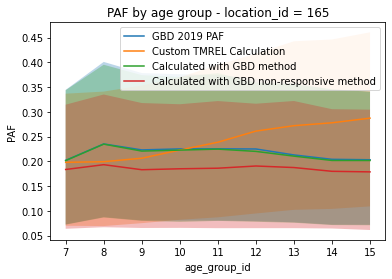

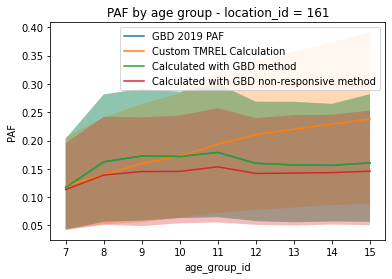

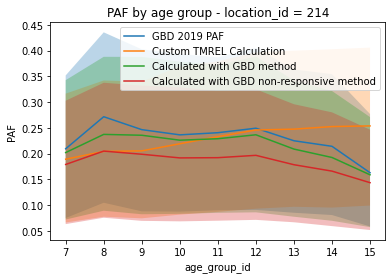

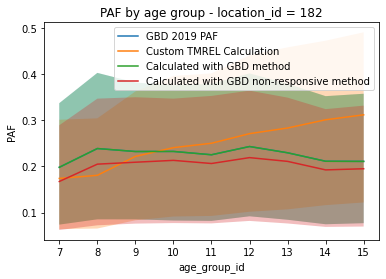

In [36]:
df_plot = df.groupby(['location_id','age_group_id']).describe(percentiles=[0.025,0.975]).reset_index()
gbd_plot = pafs.groupby(['location_id','age_group_id']).describe(percentiles=[0.025,0.975]).reset_index()
gbd_calc_plot = df_gbd.groupby(['location_id','age_group_id']).describe(percentiles=[0.025,0.975]).reset_index()
gbd_calc_nr_plot = df_gbd_nr.groupby(['location_id','age_group_id']).describe(percentiles=[0.025,0.975]).reset_index()


def compare_pafs(locs):
    for loc in locs:
        dfplot = df_plot.loc[df_plot.location_id == loc]
        gbdplot = gbd_plot.loc[gbd_plot.location_id == loc]
        gbdcalcplot = gbd_calc_plot.loc[gbd_calc_plot.location_id == loc]
        gbdcalcnrplot = gbd_calc_nr_plot.loc[gbd_calc_nr_plot.location_id == loc]
        
        fig, ax = plt.subplots()
        plt.plot(gbdplot['age_group_id'], gbdplot['value','mean'])
        plt.fill_between(gbdplot['age_group_id'], gbdplot['value','97.5%'], gbdplot['value','2.5%'], alpha=0.3)

        plt.plot(dfplot['age_group_id'], dfplot['paf','mean'])
        plt.fill_between(dfplot['age_group_id'], dfplot['paf','97.5%'], dfplot['paf','2.5%'], alpha=0.3)

        plt.plot(gbdcalcplot['age_group_id'], gbdcalcplot['paf','mean'])
        plt.fill_between(gbdcalcplot['age_group_id'], gbdcalcplot['paf','97.5%'], gbdcalcplot['paf','2.5%'], alpha=0.3)
        
        plt.plot(gbdcalcnrplot['age_group_id'], gbdcalcnrplot['paf','mean'])
        plt.fill_between(gbdcalcnrplot['age_group_id'], gbdcalcnrplot['paf','97.5%'], gbdcalcnrplot['paf','2.5%'], alpha=0.3)

        plt.xlabel('age_group_id')
        plt.ylabel('PAF')
        plt.title(f'PAF by age group - location_id = {loc}')
        plt.legend(['GBD 2019 PAF','Custom TMREL Calculation',
                   'Calculated with GBD method','Calculated with GBD non-responsive method'])
compare_pafs(locs)

In [18]:
from db_queries import get_population
pop = get_population(age_group_id=ages,
                    location_id=locs,
                    sex_id=2,
                    year_id=2019,
                    gbd_round_id=6,
                    decomp_step='step4')
pop.head()

,age_group_id,location_id,year_id,sex_id,population,run_id
0,7,161,2019,2,7.695495e+06,192
1,8,161,2019,2,7.921423e+06,192
2,9,161,2019,2,7.756269e+06,192
3,10,161,2019,2,7.297086e+06,192
4,11,161,2019,2,6.586882e+06,192


In [19]:
weighted_paf = pafs.merge(pop, on=['location_id','age_group_id'])
weighted_paf['paf_temp'] = weighted_paf['value'] * weighted_paf['population']
weighted_paf = weighted_paf.groupby(['location_id','draw'], as_index=False).sum()
weighted_paf['paf'] = weighted_paf['paf_temp'] / weighted_paf['population']
weighted_paf = weighted_paf.groupby('location_id').describe(percentiles=[0.025,0.975])
weighted_paf['paf'].head()

,count,mean,std,min,2.5%,50%,97.5%,max
location_id,,,,,,,,
161,1000.0,0.159285,0.051956,0.016240,0.057269,0.160426,0.258158,0.345915
165,1000.0,0.218977,0.071229,0.021976,0.078850,0.221189,0.357878,0.448561
182,1000.0,0.224554,0.072013,0.022347,0.081596,0.226179,0.361003,0.479899
214,1000.0,0.234650,0.073134,0.024768,0.087296,0.235334,0.373114,0.478564


In [20]:
weighted_df = df.merge(pop, on=['location_id','age_group_id'])
weighted_df['paf_temp'] = weighted_df['paf'] * weighted_df['population']
weighted_df = weighted_df.groupby(['location_id','draw'], as_index=False).sum()
weighted_df['paf'] = weighted_df['paf_temp'] / weighted_df['population']
weighted_df = weighted_df.groupby('location_id').describe(percentiles=[0.025,0.975])
weighted_df['paf'].head()

,count,mean,std,min,2.5%,50%,97.5%,max
location_id,,,,,,,,
161,1000.0,0.178216,0.056866,0.018605,0.065096,0.179571,0.284537,0.370863
165,1000.0,0.227629,0.073277,0.023534,0.082560,0.229215,0.369404,0.472111
182,1000.0,0.223935,0.071199,0.024010,0.083539,0.224157,0.361262,0.449674
214,1000.0,0.217436,0.068793,0.022267,0.081376,0.218971,0.347905,0.446870


# CONCLUSION:

Use the custom burden/paf using the methodology described in the methods appendix (orange line in the plots above) for our model